In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import random

In [3]:
def gen_initial_conditions(n):
    matriz = np.zeros((n, n))
    for i in range(n):
        matriz[i, i] = (i+1)/2

    gen_x = [1.0 - i/n for i in range(n)]
    x = [jnp.array(gen_x)]
    return matriz, x

In [4]:
def f(x, A):
    return 0.5 * x @ A @ x

calculate_grad = jax.grad(f, argnums=0)

In [5]:
def calculate_step(x_k, d_k, A):
    𝜆_k = jnp.dot(d_k, d_k) / jnp.dot(d_k, A @ d_k)
    return 𝜆_k

In [6]:
def gradient_method(iterations, A, x, 𝜆_coef, tol = 1e-5):
    d = []
    for k in range(iterations):
        gradient = calculate_grad(x[k], A)
        if jnp.linalg.norm(gradient) < tol:
            break
        d.append(-gradient)
        𝜆_k = calculate_step(x[k], d[k], A) * 𝜆_coef
        x.append(x[k] + 𝜆_k * d[k])
    return x

In [15]:
def gradient_method_with_metrics(iterations, A, x, 𝜆_coef, tol=1e-5):
    import time
    start_time = time.time()
    x_history = gradient_method(iterations, A, x, 𝜆_coef, tol)
    elapsed_time = time.time() - start_time
    
    f_values = [float(f(xi, A)) for xi in x_history]
    grad_norms = [float(jnp.linalg.norm(calculate_grad(xi, A))) for xi in x_history]
    
    iterations_done = len(x_history) - 1
    
    return {
        'x': x_history,
        'iterations': iterations_done,
        'time': elapsed_time,
        'f_values': f_values,
        'grad_norms': grad_norms,
        'final_f': f_values[-1],
        'final_grad_norm': grad_norms[-1] if grad_norms else 0
    }

In [16]:
N_values = [1, 10, 100, 1000]
𝜆_values = [0.125, 0.25, 0.5, random.uniform(0,1), 1.0]
results = []

for n in N_values:
    for 𝜆 in 𝜆_values:
        A, x = gen_initial_conditions(n)
        metrics = gradient_method_with_metrics(10000, A, x, 𝜆_coef=𝜆)
        
        results.append({
            'N': n,
            'λ': 𝜆,
            'Iterações': metrics['iterations'],
            'Tempo (s)': metrics['time'],
            'f(x_final)': metrics['final_f'],
            '||∇f(x_final)||': metrics['final_grad_norm'],
            'metrics': metrics
        })

df = pd.DataFrame([{k: v for k, v in r.items() if k != 'metrics'} for r in results])
print("="*70)
print("RESULTADOS - Método do Gradiente")
print("="*70)
print(df.to_string(index=False))
print("="*70)

RESULTADOS - Método do Gradiente
   N        λ  Iterações  Tempo (s)   f(x_final)  ||∇f(x_final)||
   1 0.125000         82   0.057719 7.713670e-11         0.000009
   1 0.250000         38   0.025436 7.990907e-11         0.000009
   1 0.500000         16   0.010751 5.820766e-11         0.000008
   1 0.612911         12   0.008509 3.201808e-11         0.000006
   1 1.000000          1   0.001279 0.000000e+00         0.000000
  10 0.125000         97   0.062828 8.521593e-11         0.000009
  10 0.250000         53   0.034904 7.341080e-11         0.000009
  10 0.500000         38   0.025190 6.012674e-11         0.000008
  10 0.612911         33   0.021980 4.780956e-11         0.000008
  10 1.000000         56   0.036341 4.769940e-11         0.000009
 100 0.125000        329   0.222715 9.474675e-11         0.000010
 100 0.250000        249   0.168610 8.479142e-11         0.000009
 100 0.500000        191   0.128393 8.622503e-11         0.000009
 100 0.612911        163   0.110792 7.83317

Geração do Dashboard
(http://127.0.0.1:8050/)

In [19]:
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np


app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Análise do Método do Gradiente com Busca Exata"),
    html.Div([
        html.H2("Selecione o tipo de gráfico:"),
        dcc.RadioItems(
            id='plot-type',
            options=[
                {'label': 'Convergência', 'value': 'convergence'},
                {'label': 'Dimensão (Iterações e Tempo)', 'value': 'dimension'}
            ],
            value='convergence'
        ),

        html.H2("Selecione o valor de λ:"),
        dcc.Dropdown(
            id='lambda-dropdown',
            options=[{'label': f'λ = {lam}', 'value': lam} for lam in sorted(set(r['λ'] for r in results))],
            value=sorted(set(r['λ'] for r in results))[0] if results else None,
            clearable=False
        ),

        dcc.Graph(id='results')
    ])
])

@app.callback(
    Output('results', 'figure'),
    [Input('plot-type', 'value'), Input('lambda-dropdown', 'value')]
 )
def run_plot(plot_type, selected_lambda):
    # Guard clauses
    if not results:
        return go.Figure()
    filtered_results = [r for r in results if r['λ'] == selected_lambda]
    if not filtered_results:
        return go.Figure()

    if plot_type == 'convergence':
        rows, cols = 2, 2
        subplot_titles = [f"N={r['N']}  λ={r['λ']}  ({r['Iterações']} iter)" for r in filtered_results]
        fig = make_subplots(rows=rows, cols=cols, subplot_titles=subplot_titles, vertical_spacing=0.12, horizontal_spacing=0.10)

        # prepare log-scale common range
        eps = 1e-30
        all_vals = []
        for r in filtered_results:
            ys = np.array(r['metrics']['f_values'], dtype=float)
            ys = np.maximum(ys, eps)
            all_vals.append(ys)
        stacked = np.concatenate(all_vals) if len(all_vals) > 0 else np.array([eps])
        y_min = np.min(stacked); y_max = np.max(stacked)
        if y_min <= 0:
            y_min = eps
        log_ymin = np.log10(y_min)
        log_ymax = np.log10(max(y_max, y_min * (10 ** -6)))
        pad = max(0.5, (log_ymax - log_ymin) * 0.1)
        range_log = [log_ymin - pad, log_ymax + pad]

        for idx, result in enumerate(filtered_results):
            row = (idx // cols) + 1
            col = (idx % cols) + 1
            metrics = result['metrics']
            ys = np.array(metrics['f_values'], dtype=float)
            ys_clipped = np.maximum(ys, eps)
            iter_x = list(range(len(ys_clipped)))
            fig.add_trace(
                go.Scatter(
                    x=iter_x,
                    y=ys_clipped,
                    mode='lines',
                    line=dict(color='blue', width=2),
                    name=f"N = {result['N']}",
                    hovertemplate='iter=%{x}<br>f=%{y}<extra></extra>'
                ),
                row=row, col=col,
            )
            fig.update_yaxes(type='log', row=row, col=col, title_text='f(x)', range=range_log, tickformat='.3e', exponentformat='e')
            fig.update_xaxes(title_text='Iteração', row=row, col=col)

        fig.update_layout(height=700, showlegend=False, title_text=f'Convergência do Método do Gradiente (λ = {selected_lambda})', font=dict(size=11), margin=dict(t=80, b=60))
        return fig

    elif plot_type == 'dimension':
        fig = make_subplots(rows=1, cols=2, subplot_titles=['Iterações necessárias vs Dimensão', 'Tempo de Execução vs Dimensão'])
        filtered_results = [r for r in results if r['λ'] == selected_lambda]
        if not filtered_results:
            return go.Figure()
        N_values = sorted(set(r['N'] for r in filtered_results))
        iterations_by_N = [next(r['Iterações'] for r in filtered_results if r['N'] == n) for n in N_values]
        time_by_N = [next(r['Tempo (s)'] for r in filtered_results if r['N'] == n) for n in N_values]

        fig.add_trace(
            go.Scatter(
                x=N_values,
                y=iterations_by_N,
                mode='lines+markers',
                marker=dict(size=8),
                line=dict(width=2),
                name='Iterações',
                hovertemplate='N=%{x}<br>iter=%{y}<extra></extra>'
            ),
            row=1, col=1
        )

        fig.add_trace(
            go.Scatter(
                x=N_values,
                y=time_by_N,
                mode='lines+markers',
                marker=dict(size=8, symbol='square'),
                line=dict(width=2, color='green'),
                name='Tempo (s)',
                hovertemplate='N=%{x}<br>time=%{y}s<extra></extra>'
            ),
            row=1, col=2
        )

        fig.update_xaxes(type='log', title_text='N (dimensão)')
        fig.update_yaxes(title_text='Iterações', row=1, col=1, tickformat='.3e', exponentformat='e')
        fig.update_yaxes(title_text='Tempo (s)', row=1, col=2, tickformat='.3e', exponentformat='e')
        fig.update_layout(height=500, showlegend=False, title_text=f'Métricas vs Dimensão (λ = {selected_lambda})', margin=dict(t=80, b=60))
        return fig

    return go.Figure()

if __name__ == '__main__':
    app.run(debug=True)

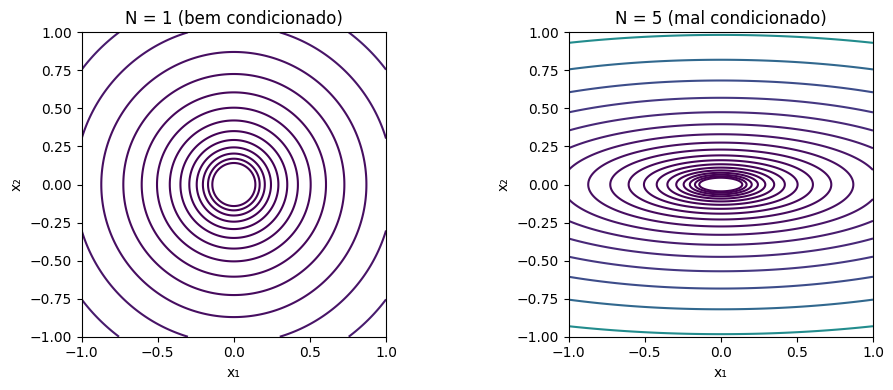

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def quadratic_contours(A, ax, title):
    x = np.linspace(-1, 1, 400)
    y = np.linspace(-1, 1, 400)
    X, Y = np.meshgrid(x, y)
    Z = 0.5 * (A[0,0]*X**2 + 2*A[0,1]*X*Y + A[1,1]*Y**2)
    
    ax.contour(X, Y, Z, levels=np.logspace(-2, 1, 20), cmap='viridis')
    ax.set_title(title)
    ax.set_xlabel('x₁')
    ax.set_ylabel('x₂')
    ax.set_aspect('equal')

A1 = np.array([[1, 0],
               [0, 1]])

A2 = np.array([[1, 0],
                 [0, 10]])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
quadratic_contours(A1, axes[0], "N = 1 (bem condicionado)")
quadratic_contours(A2, axes[1], "N = 5 (mal condicionado)")

plt.tight_layout()
plt.show()
